<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
Bioanformatic <br>
<font color=2565AE size=5>
Computer Engineering Department <br>
FALL 2025<br>
<font color=3C99D size=5>
RNA-Seq Analysis <br>
<font color=696880 size=4>
Mohammadreza Monemian 402106604

____________

# Part 0: install package

In [40]:
#instaling packages
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("GEOquery")
BiocManager::install(c("edgeR", "limma"))
install.packages("pheatmap")
library(pheatmap)
library(edgeR)
library(limma)
library(GEOquery)
library(ggplot2)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.22 (BiocManager 1.30.27), R 4.5.2 (2025-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'GEOquery'”
Old packages: 'selectr', 'tidyr', 'xfun'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.22 (BiocManager 1.30.27), R 4.5.2 (2025-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'edgeR' 'limma'”
Old packages: 'selectr', 'tidyr', 'xfun'

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Part 1: Data Download and Preparation

In [41]:
#downloading dataset
gse_id <- "GSE270045"
getGEOSuppFiles(gse_id)

list.files(paste0(gse_id))

Using locally cached version of supplementary file(s) GSE270045 found here:
/content/GSE270045/GSE270045_LC_counts.tsv.gz 



,size,isdir,mode,mtime,ctime,atime,uid,gid,uname,grname,fname,destdir,filepath,GEO
,<dbl>,<lgl>,<octmode>,<dttm>,<dttm>,<dttm>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
/content/GSE270045/GSE270045_LC_counts.tsv.gz,2516221,FALSE,644,2025-12-20 11:05:16,2025-12-20 11:05:16,2025-12-20 11:05:19,0,0,root,root,GSE270045_LC_counts.tsv.gz,/content/GSE270045,/content/GSE270045/GSE270045_LC_counts.tsv.gz,GSE270045


[1] "GSE270045_LC_counts.tsv.gz"

In [42]:
#convert to matrix
file_path <- "GSE270045/GSE270045_LC_counts.tsv.gz"

data_matrix <- read.delim(file_path, row.names = 1, check.names = FALSE)

print(paste("number of gen:", nrow(data_matrix)))
print(paste("number of sample:", ncol(data_matrix)))

head(data_matrix[, 1:5])

[1] "number of gen: 28889"
[1] "number of sample: 36"


,CCI031,CCI041,CCI042,CCI050,CCI064
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5S_rRNA,0.000000,0.00000,0.000000,0.00000,0.00000
A1BG,92.103500,105.87411,85.063750,110.46840,52.29464
A1CF,9.103139,25.11204,8.072486,12.13559,10.09736
A2M,60.021740,125.18732,129.918560,145.73940,98.72202
A2ML1,13.652440,39.72340,21.217640,33.96565,7.28073
A2MP1,28.999990,61.99998,45.000040,67.00004,21.41833


In [43]:
#show dimention data_matrix
dim(data_matrix)

[1] 28889    36

In [44]:
#show for 5s_rRNA
rRNA_data <- data_matrix["5S_rRNA", ]
print(rRNA_data)

mean(as.numeric(rRNA_data))

        CCI031 CCI041 CCI042 CCI050 CCI064 CCI069 CCI077 CCI088 CCI12  CCI136
5S_rRNA      0      0      0      0      0 1.0116      0      0     0 1.15624
        CCI138 CCI58 CCI93 HP1193 HP1194 HP1301 HP851 S013_11 S014_11 S016_11
5S_rRNA      0     0     0      0      0      0     0       0       0       0
        S020_11 S023_11 S024_11 S025_11  S026_11 S027_11 S029_11  S030_11
5S_rRNA 1.25403       0       0       0 0.857024       0       1 0.116938
        S032_11 S033_11 S034_11 S035_11 S038_11 S039_11 S041_11 S042_11
5S_rRNA       0       0       0       1       0       0       0       0


[1] 0.177662

In [45]:
 # Check if there are any missing values in the dataset
 any(is.na(data_matrix))
 # Ensure all expression values are non-negative
 any(data_matrix < 0)
# Get the minimum and maximum values to verify data scale
 range(data_matrix)

[1] FALSE

[1] FALSE

[1]     0.00 95726.72

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 647288 2212155 3120772 3378446 4161133 8678469 

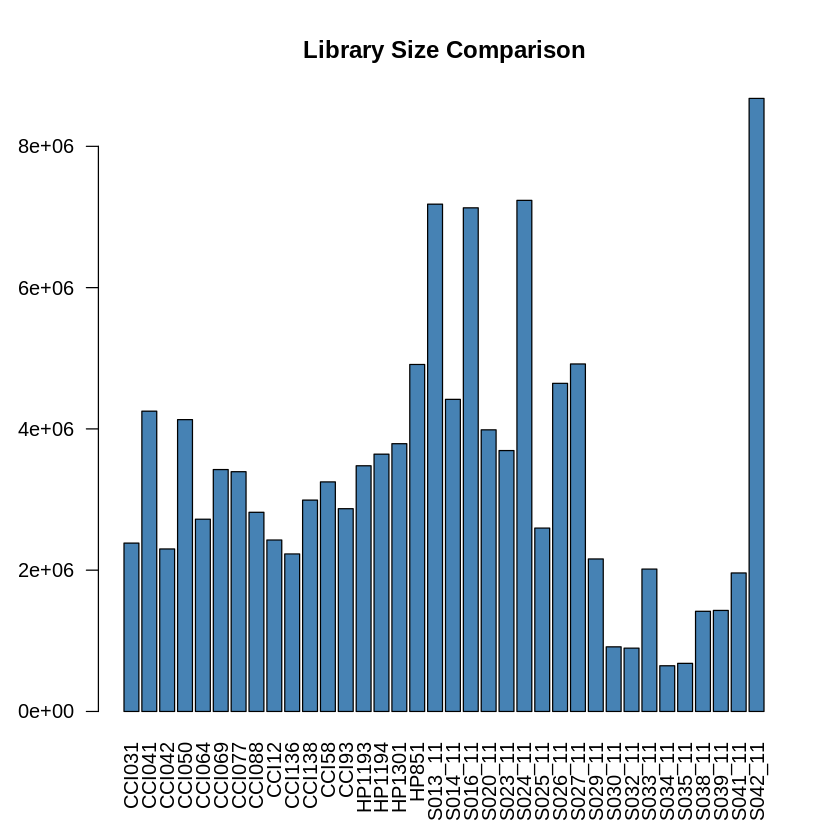

In [46]:
# Calculate the total number of reads per sample
library_sizes <- colSums(data_matrix)
# Display statistical summary (Min, Max, Mean) of library sizes
summary(library_sizes)
# Visualize read depth distribution across samples
barplot(library_sizes, main="Library Size Comparison", las=2, col="steelblue")

# Part 2: Metadata Construction and Experimental Design

In this section, we create the sample information table (Metadata) to define the experimental groups (Control vs. ME_CFS). This step is crucial for mapping each sample to its respective condition.

In [47]:
# Download GSE270045 metadata and extract phenotype info for sample grouping
gse <- getGEO("GSE270045", destdir = ".", getGPL = FALSE)
metadata <- pData(gse[[1]])

# Preview titles to identify Healthy vs. Long Covid samples
metadata

Found 1 file(s)

GSE270045_series_matrix.txt.gz

Using locally cached version: ./GSE270045_series_matrix.txt.gz



,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,characteristics_ch1,⋯,library_selection,library_source,library_strategy,relation,relation.1,supplementary_file_1,cell type:ch1,sample id:ch1,tissue:ch1,treatment:ch1
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GSM8333270,Healthy Control 1,GSM8333270,Public on Oct 15 2024,Jun 17 2024,Oct 15 2024,SRA,1,whole blood,Homo sapiens,tissue: whole blood,⋯,cDNA,transcriptomic,RNA-Seq,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24949172,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN41876995,NONE,whole blood,CCI031,whole blood,No
GSM8333271,Healthy Control 2,GSM8333271,Public on Oct 15 2024,Jun 17 2024,Oct 15 2024,SRA,1,whole blood,Homo sapiens,tissue: whole blood,⋯,cDNA,transcriptomic,RNA-Seq,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24949173,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN41876994,NONE,whole blood,CCI041,whole blood,No
GSM8333272,Healthy Control 3,GSM8333272,Public on Oct 15 2024,Jun 17 2024,Oct 15 2024,SRA,1,whole blood,Homo sapiens,tissue: whole blood,⋯,cDNA,transcriptomic,RNA-Seq,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24949174,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN41876993,NONE,whole blood,CCI042,whole blood,No
GSM8333273,Healthy Control 4,GSM8333273,Public on Oct 15 2024,Jun 17 2024,Oct 15 2024,SRA,1,whole blood,Homo sapiens,tissue: whole blood,⋯,cDNA,transcriptomic,RNA-Seq,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24949175,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN41876992,NONE,whole blood,CCI050,whole blood,No
GSM8333274,Healthy Control 5,GSM8333274,Public on Oct 15 2024,Jun 17 2024,Oct 15 2024,SRA,1,whole blood,Homo sapiens,tissue: whole blood,⋯,cDNA,transcriptomic,RNA-Seq,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24949176,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN41876991,NONE,whole blood,CCI064,whole blood,No
GSM8333275,Healthy Control 6,GSM8333275,Public on Oct 15 2024,Jun 17 2024,Oct 15 2024,SRA,1,whole blood,Homo sapiens,tissue: whole blood,⋯,cDNA,transcriptomic,RNA-Seq,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24949177,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN41876990,NONE,whole blood,CCI069,whole blood,No
GSM8333276,Healthy Control 7,GSM8333276,Public on Oct 15 2024,Jun 17 2024,Oct 15 2024,SRA,1,whole blood,Homo sapiens,tissue: whole blood,⋯,cDNA,transcriptomic,RNA-Seq,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24949178,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN41876989,NONE,whole blood,CCI077,whole blood,No
GSM8333277,Healthy Control 8,GSM8333277,Public on Oct 15 2024,Jun 17 2024,Oct 15 2024,SRA,1,whole blood,Homo sapiens,tissue: whole blood,⋯,cDNA,transcriptomic,RNA-Seq,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24949179,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN41876988,NONE,whole blood,CCI088,whole blood,No
GSM8333278,Healthy Control 9,GSM8333278,Public on Oct 15 2024,Jun 17 2024,Oct 15 2024,SRA,1,whole blood,Homo sapiens,tissue: whole blood,⋯,cDNA,transcriptomic,RNA-Seq,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24949180,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN41876987,NONE,whole blood,CCI12,whole blood,No


In [48]:
# Create a data frame with sample IDs and titles from the metadata
sample_info <- data.frame(title = metadata$title)

# Assign groups: 'Control' if title contains 'Healthy', otherwise 'ME_CFS'
sample_info$group <- ifelse(grepl("Healthy", sample_info$title), "Control", "ME_CFS")

# Convert the group column into a factor for downstream statistical analysis
sample_info$group <- as.factor(sample_info$group)

# Display the total count of samples in each group to verify the split
table(sample_info$group)


Control  ME_CFS 
     17      19 

In [49]:
# Extract clean sample IDs from the specific column using backticks
# This removes the "sample id: " text to keep only the ID (e.g., CCI031)
sample_ids <- gsub("sample id: ", "", metadata$`sample id:ch1`)

# Ensure the IDs are now correct and clean
print(head(sample_ids))

# Update your sample_info data frame with these clean IDs
sample_info$sample_id <- sample_ids

[1] "CCI031" "CCI041" "CCI042" "CCI050" "CCI064" "CCI069"


In [50]:
# Check if metadata IDs match expression matrix column names
all(colnames(data_matrix) == sample_info$sample_id)

[1] TRUE

In [51]:
# Set the row names of the data frame to be the sample IDs
rownames(sample_info) <- sample_ids


#remove title from table
sample_info$title <- NULL

# Verify the final structure of your metadata table
sample_info

,group,sample_id
,<fct>,<chr>
CCI031,Control,CCI031
CCI041,Control,CCI041
CCI042,Control,CCI042
CCI050,Control,CCI050
CCI064,Control,CCI064
CCI069,Control,CCI069
CCI077,Control,CCI077
CCI088,Control,CCI088
CCI12,Control,CCI12


# Part 3: Exploratory Data Analysis (EDA)

In this section, we perform an exploratory analysis of the gene expression data to assess sample relationships, identify potential outliers, and visualize the overall data distribution.

In [52]:
# Calculate Descriptive Statistics
# We convert the matrix to a vector to get a global summary of all expression values
global_stats <- summary(as.vector(as.matrix(data_matrix)))

#  Format and Print the Report
cat("==================================================\n")
cat("   GENE EXPRESSION MATRIX REPORT     \n")
cat("==================================================\n\n")

cat("--- Summary Statistics ---\n")
print(global_stats)
cat("\n")

cat("--- Data Integrity Checks ---\n")
cat("Any Missing Values (NAs)?:  ", any(is.na(data_matrix)), "\n")
cat("Any Negative Values?:      ", any(data_matrix < 0), "\n")
cat("Value Range (Min to Max):  ", range(data_matrix)[1], " to ", range(data_matrix)[2], "\n\n")

cat("--- Conclusion on Data Type ---\n")
# Check if data consists of large integers (Raw Counts) or decimals (Normalized)
if(max(data_matrix) > 1000 & all(data_matrix %% 1 == 0)) {
  cat("Result: Data appears to be RAW COUNTS (Integers, no negatives, high range).\n")
} else {
  cat("Result: Data appears to be NORMALIZED or LOG-TRANSFORMED.\n")
}
cat("==================================================\n")

   GENE EXPRESSION MATRIX REPORT     

--- Summary Statistics ---
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    0.000     0.000     4.622   116.946    60.607 95726.724 

--- Data Integrity Checks ---
Any Missing Values (NAs)?:   FALSE 
Any Negative Values?:       FALSE 
Value Range (Min to Max):   0  to  95726.72 

--- Conclusion on Data Type ---
Result: Data appears to be NORMALIZED or LOG-TRANSFORMED.



Library Size Highlights:
- Smallest Library Size:  S034_11  ( 647288.5 )
- Largest Library Size:   S042_11  ( 8678469 )
--- Average Library Size (Total Depth) ---
Control Group:  3236356 
ME_CFS Group:   3505578 


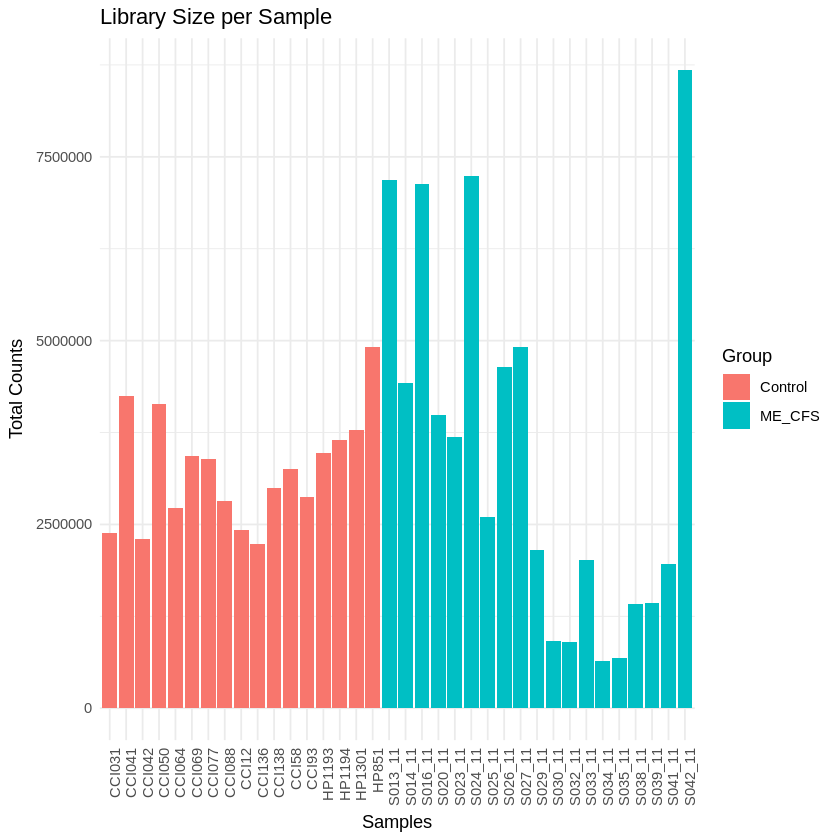

In [53]:
#  Calculate Library Size
lib_size <- colSums(data_matrix)

# Create a data frame for visualization
df_lib <- data.frame(
  Sample = names(lib_size),
  LibrarySize = lib_size,
  Group = sample_info$group
)

# Identify Smallest and Largest
cat("\nLibrary Size Highlights:\n")
cat("- Smallest Library Size: ", df_lib$Sample[which.min(lib_size)], " (", min(lib_size), ")\n")
cat("- Largest Library Size:  ", df_lib$Sample[which.max(lib_size)], " (", max(lib_size), ")\n")

#  Separate the matrix by groups
control_samples <- data_matrix[, sample_info$group == "Control"]
me_cfs_samples  <- data_matrix[, sample_info$group == "ME_CFS"]


#  Calculate Mean Library Size per group (Average total counts)
mean_lib_control <- mean(colSums(control_samples))
mean_lib_me_cfs  <- mean(colSums(me_cfs_samples))


cat("--- Average Library Size (Total Depth) ---\n")
cat("Control Group: ", mean_lib_control, "\n")
cat("ME_CFS Group:  ", mean_lib_me_cfs,  "\n")
cat("==================================================\n")

# Plotting with ggplot2
library(ggplot2)
ggplot(df_lib, aes(x = Sample, y = LibrarySize, fill = Group)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  labs(title = "Library Size per Sample", x = "Samples", y = "Total Counts") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

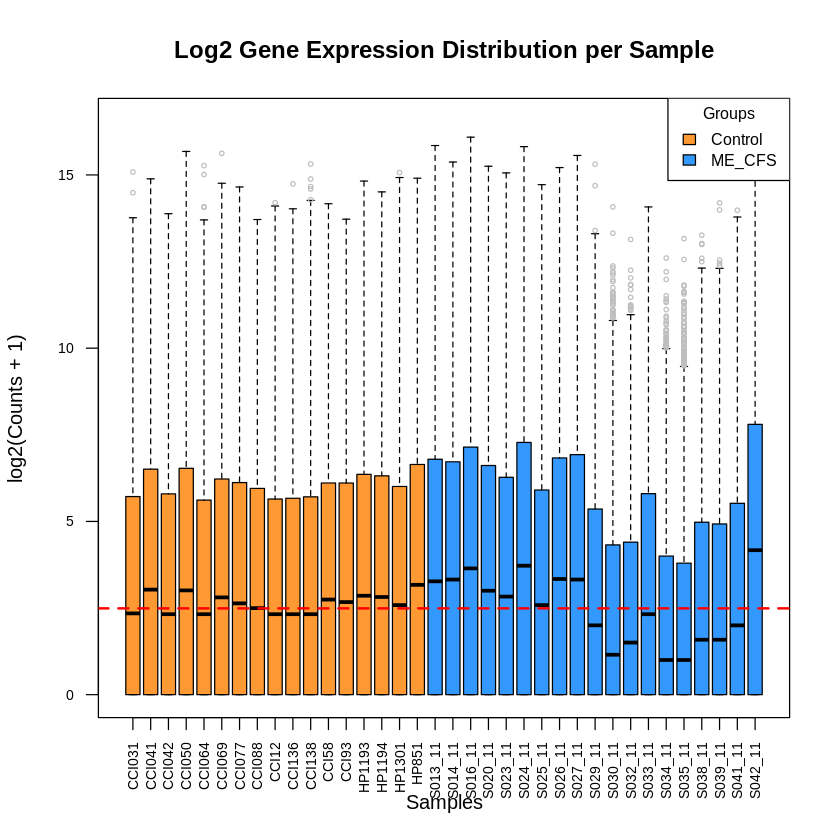

In [54]:
# 1. Log2 Transformation
log_counts <- log2(data_matrix + 1)

# 2. Define High-Contrast Colors
# Orange for Control, Sky Blue for ME_CFS
group_cols <- c("#FF9933", "#3399FF")
names(group_cols) <- c("Control", "ME_CFS")

# 3. Plotting the Boxplot with 3 Quartiles visible
boxplot(log_counts,
        col = group_cols[sample_info$group],
        main = "Log2 Gene Expression Distribution per Sample",
        ylab = "log2(Counts + 1)",
        xlab = "Samples",
        las = 2,           # Rotate x-axis labels 90 degrees
        cex.axis = 0.7,    # Font size for sample names
        border = "black",  # Outline color for boxes
        outcol = "grey",   # Color for outliers (the dots)
        outcex = 0.5)      # Size of outliers

# 4. Add the Legend
legend("topright",
       legend = names(group_cols),
       fill = group_cols,
       title = "Groups",
       cex = 0.8)

# 5. Add a reference line for the Overall Median
abline(h = median(as.matrix(log_counts)), col = "red", lty = 2, lwd = 2)

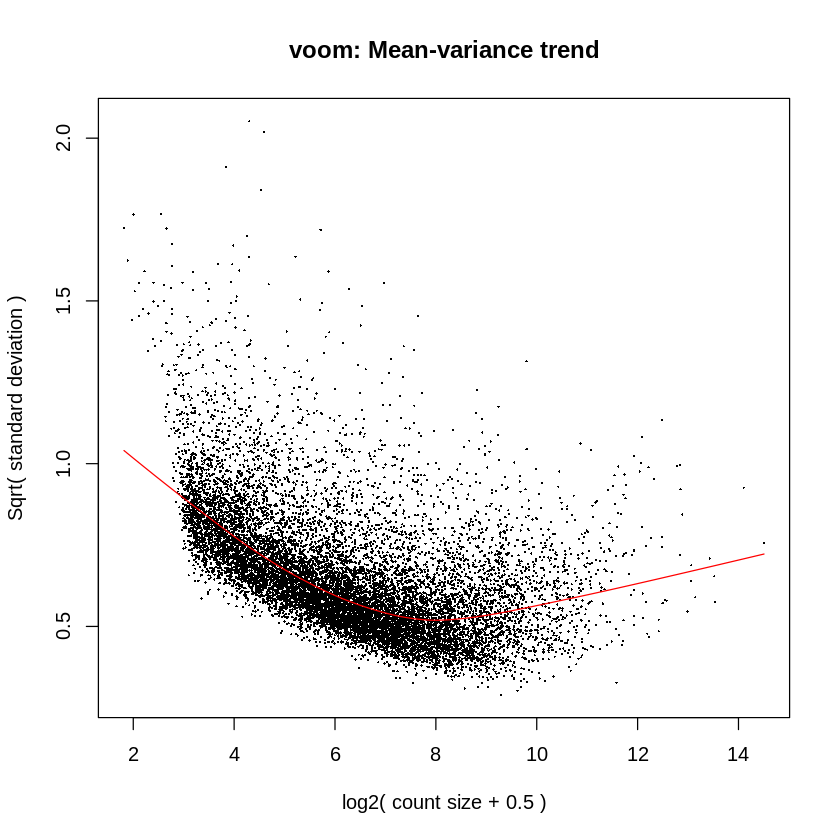

In [55]:
# 1. Create a specialized DGEList object to store counts and group metadata
dge <- DGEList(counts = data_matrix, group = sample_info$group)

# 2. Remove lowly expressed genes to reduce noise and improve statistical power
# filterByExpr automatically determines which genes have enough counts to be kept
keep <- filterByExpr(dge)
dge <- dge[keep, , keep.lib.sizes = FALSE]

# 3. Calculate normalization factors using the TMM method
# This step accounts for differences in sequencing depth (library size) between samples
dge <- calcNormFactors(dge)

# 4. Define the Design Matrix to specify the groups for comparison (Control vs. ME_CFS)
design <- model.matrix(~ group, data = sample_info)

# 5. Execute voom transformation and plot the Mean-Variance Trend
# This converts counts to log-CPM and calculates weights to handle technical noise
v <- voom(dge, design, plot = TRUE)

# Part 4: Principal Component Analysis (PCA)

In this section, we apply Principal Component Analysis (PCA) to visualize the high-dimensional gene expression data in a 2D space. This allows us to assess the biological variance and determine if the samples cluster naturally based on their clinical status (ME_CFS vs. Control).


--- PCA Variance Summary ---
  Component Variance_Percentage
1       PC1               60.17
2       PC2                4.54
3       PC3                3.44
4       PC4                1.60
5       PC5                1.55
----------------------------
PC1 explains: 60.17%
PC2 explains: 4.54%
PC3 explains: 3.44%

--- Preparing PCA Plot (PC1 vs PC2) ---
Plotting PC1 (60.17%) against PC2 (4.54%) ...

--- PCA Explained Variance (Scree Plot Data) ---
PC1: 60.17% of total variance explained
PC2: 4.54% of total variance explained
PC3: 3.44% of total variance explained
PC4: 1.6% of total variance explained
PC5: 1.55% of total variance explained
----------------------------------------------


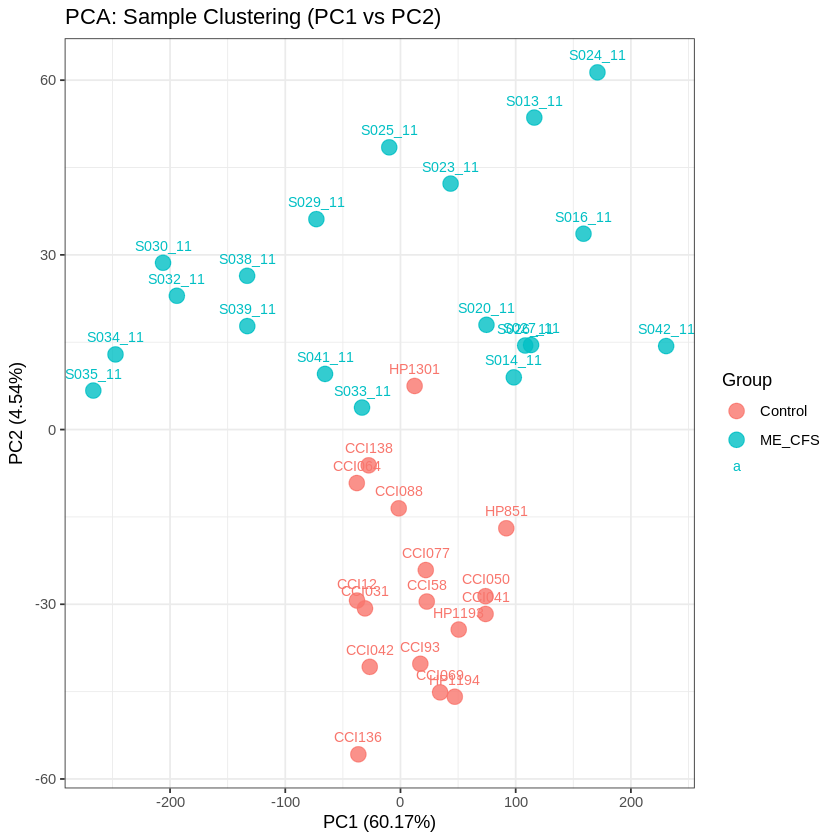

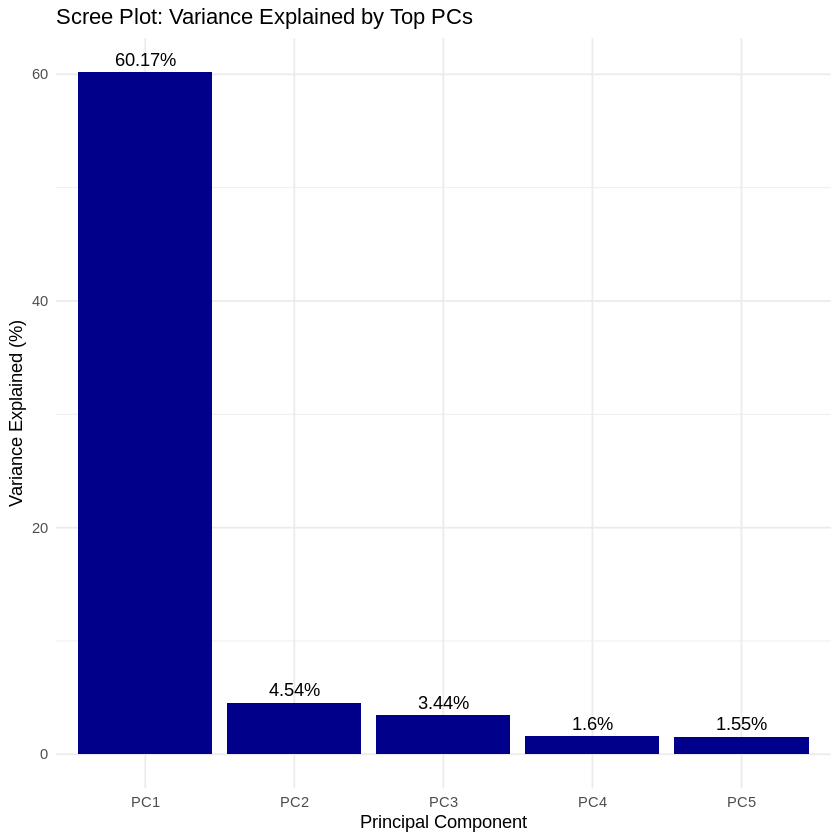

In [56]:
# Calculate variance for each gene (row-wise)
gene_vars <- apply(log_counts, 1, var)

# Keep only genes above the 25th percentile of variance to reduce noise
threshold <- quantile(gene_vars, 0.25)
data_filtered <- log_counts[gene_vars > threshold, ]

# prcomp expects samples as rows and genes as columns
data_for_pca <- t(data_filtered)
pca_results <- prcomp(data_for_pca, center = TRUE, scale. = FALSE)


# Calculate the percentage of variance for each Principal Component
var_explained <- (pca_results$sdev^2 / sum(pca_results$sdev^2)) * 100

# Create a clean table for the first 5 components
pc_table <- data.frame(
  Component = paste0("PC", 1:5),
  Variance_Percentage = round(var_explained[1:5], 2)
)
cat("\n--- PCA Variance Summary ---\n")
print(pc_table)
cat("----------------------------\n")
# Specifically answering your questions from image 3
cat(paste0("PC1 explains: ", pc_table$Variance_Percentage[1], "%\n"))
cat(paste0("PC2 explains: ", pc_table$Variance_Percentage[2], "%\n"))
cat(paste0("PC3 explains: ", pc_table$Variance_Percentage[3], "%\n"))



# Print instructions for the user to understand the plot
cat("\n--- Preparing PCA Plot (PC1 vs PC2) ---\n")
cat(paste0("Plotting PC1 (", pc_table$Variance_Percentage[1], "%) against PC2 (", pc_table$Variance_Percentage[2], "%) ...\n"))

# The actual plotting code
pca_plot_df <- as.data.frame(pca_results$x)
pca_plot_df$Group <- sample_info$group

pca_scatter <- ggplot(pca_plot_df, aes(x = PC1, y = PC2, color = Group)) +
  geom_point(size = 4, alpha = 0.8) +
  geom_text(aes(label = rownames(pca_plot_df)), vjust = -1.2, size = 3) +
  labs(
    title = "PCA: Sample Clustering (PC1 vs PC2)",
    x = paste0("PC1 (", pc_table$Variance_Percentage[1], "%)"),
    y = paste0("PC2 (", pc_table$Variance_Percentage[2], "%)")
  ) +
  theme_bw()

# Show the scatter plot
print(pca_scatter)


cat("\n--- PCA Explained Variance (Scree Plot Data) ---\n")
# Print each PC and its contribution clearly for answering questions
for(i in 1:nrow(pc_table)) {
  cat(paste0(pc_table$Component[i], ": ", pc_table$Variance_Percentage[i], "% of total variance explained\n"))
}
cat("----------------------------------------------\n")

# The actual Bar Chart code
scree_plot <- ggplot(pc_table, aes(x = reorder(Component, -Variance_Percentage), y = Variance_Percentage)) +
  geom_bar(stat = "identity", fill = "darkblue") +
  geom_text(aes(label = paste0(Variance_Percentage, "%")), vjust = -0.5) +
  labs(
    title = "Scree Plot: Variance Explained by Top PCs",
    x = "Principal Component",
    y = "Variance Explained (%)"
  ) +
  theme_minimal()

# Show the bar chart
print(scree_plot)



# Part 5: Differential Expression Analysis with limma-voom

In this section, we transition from data exploration to formal statistical testing. We use the **limma-voom** pipeline to identify genes that are significantly differentially expressed between the **ME_CFS** and **Control** groups.

In [57]:
# 1. Create DGEList and calculate TMM normalization factors
dge <- DGEList(counts = data_matrix, group = sample_info$group)
dge <- calcNormFactors(dge)
cat("Normalization factors calculated using TMM method.\n")

# 2. Filter lowly expressed genes
keep <- filterByExpr(dge)
dge <- dge[keep, , keep.lib.sizes = FALSE]
cat("Filtering complete. Number of genes remaining:", sum(keep), "\n")

# 3. Create design matrix (Setting Control as reference)
design <- model.matrix(~ group, data = sample_info)
colnames(design) <- gsub("group", "", colnames(design))
cat("Design matrix created. Groups being compared:", colnames(design)[2], "vs Control\n")

Normalization factors calculated using TMM method.
Filtering complete. Number of genes remaining: 13154 
Design matrix created. Groups being compared: ME_CFS vs Control


Voom transformation applied. Mean-variance trend plot generated.


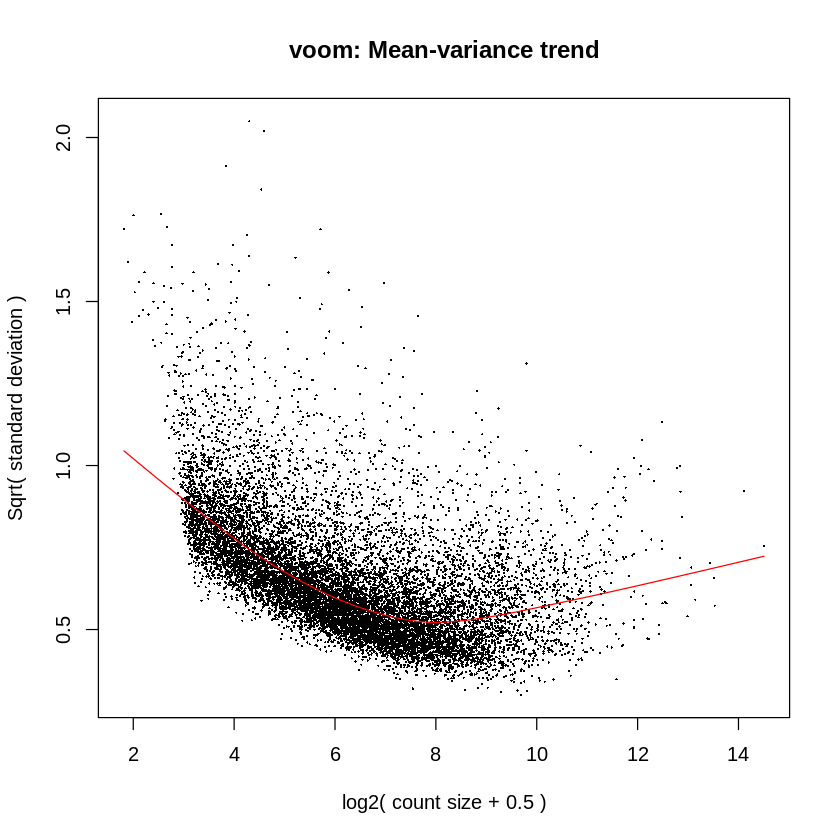

In [58]:
# 4. Run voom transformation to model mean-variance relationship
# This generates the weights needed for the linear model
v <- voom(dge, design, plot = TRUE)
cat("Voom transformation applied. Mean-variance trend plot generated.\n")

In [59]:
# 5. Fit linear model to the weighted data
fit <- lmFit(v, design)

# 6. Apply Empirical Bayes smoothing for robust statistics
fit <- eBayes(fit)
# Extract results table
results <- topTable(fit, coef = 2, number = Inf, sort.by = "P")

cat("\n---  Top 3 DEGs ---\n")
top_3 <- head(results, 3)
for(i in 1:3) {
  gene_name <- rownames(top_3)[i]
  lfc <- top_3$logFC[i]
  adj_p <- top_3$adj.P.Val[i]

  # Interpretation of expression group
  direction <- ifelse(lfc > 0, "ME_CFS (Up-regulated)", "Control (Down-regulated)")

  cat(paste0(i, ". Gene: ", gene_name,
             " | logFC: ", round(lfc, 3),
             " | adj.P.Val: ", formatC(adj_p, format = "e", digits = 2),
             " | Higher expression in: ", direction, "\n"))
}


cat("Statistical testing complete. Top genes identified.\n")
print(head(results)) # Displays logFC, AveExpr, P.Value, adj.P.Val


---  Top 3 DEGs ---
1. Gene: TAF1D | logFC: 0.958 | adj.P.Val: 1.02e-11 | Higher expression in: ME_CFS (Up-regulated)
2. Gene: ZBTB7A | logFC: -0.733 | adj.P.Val: 1.87e-11 | Higher expression in: Control (Down-regulated)
3. Gene: MAP1S | logFC: -0.902 | adj.P.Val: 1.87e-11 | Higher expression in: Control (Down-regulated)
Statistical testing complete. Top genes identified.
            logFC  AveExpr         t      P.Value    adj.P.Val        B
TAF1D   0.9582058 6.205309  13.18525 7.724550e-16 1.016087e-11 25.92099
ZBTB7A -0.7329935 7.490320 -12.45954 4.547344e-15 1.870646e-11 24.18504
MAP1S  -0.9022549 6.113502 -12.39234 5.375857e-15 1.870646e-11 24.04059
PLEC   -0.9977983 9.253662 -12.29399 6.875111e-15 1.870646e-11 23.64819
SCAF1  -0.9875261 6.492985 -12.28056 7.110559e-15 1.870646e-11 23.76932
CIC    -0.8478609 7.763672 -12.12649 1.048130e-14 2.297850e-11 23.36374


Summary of Differential Expression:

 Down-regulated Not Significant    Up-regulated 
             93           12984              77 
Generating Heatmap for the top 50 most significant genes...


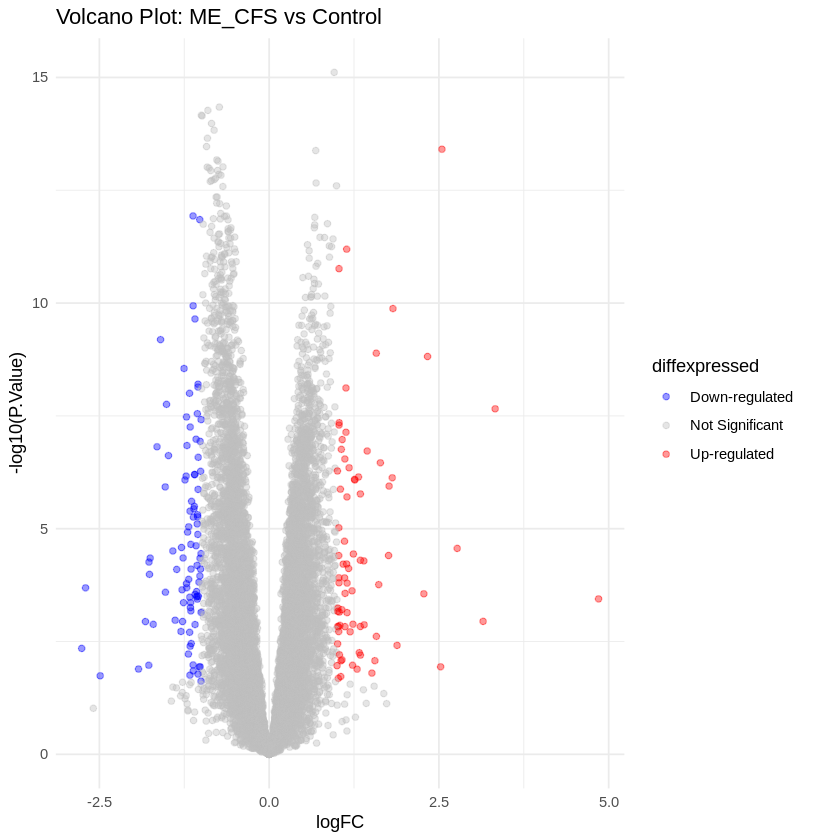

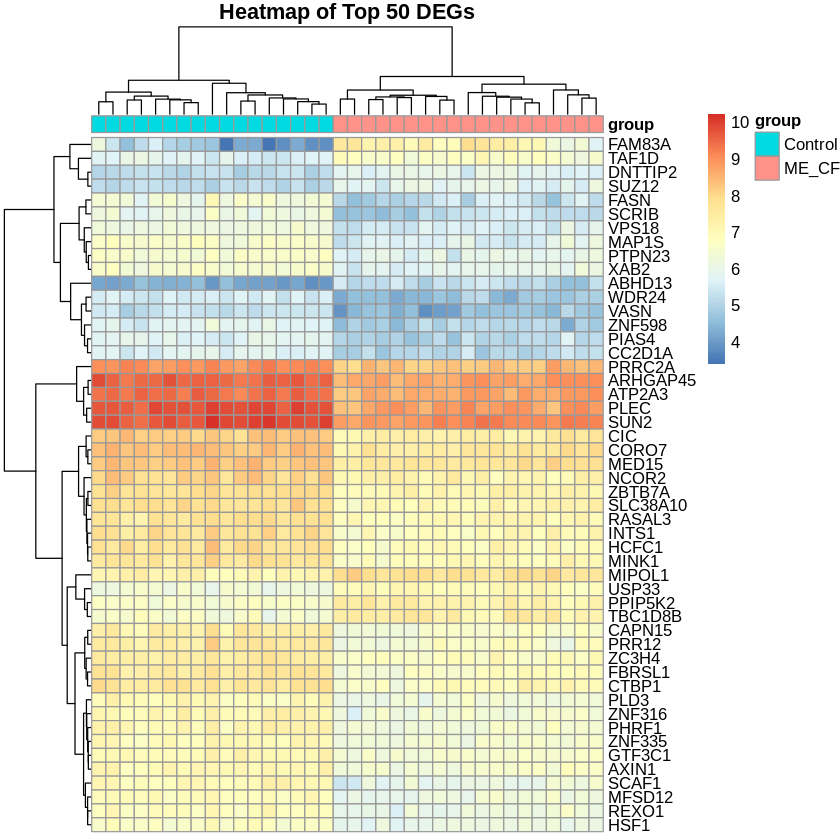

In [60]:
# 7. Identify significant genes (|logFC| > 1 and adj.P.Val < 0.05)
results$diffexpressed <- "Not Significant"
results$diffexpressed[results$logFC > 1 & results$adj.P.Val < 0.05] <- "Up-regulated"
results$diffexpressed[results$logFC < -1 & results$adj.P.Val < 0.05] <- "Down-regulated"

cat("Summary of Differential Expression:\n")
print(table(results$diffexpressed))

# Plotting Volcano Plot
ggplot(data=results, aes(x=logFC, y=-log10(P.Value), col=diffexpressed)) +
    geom_point(alpha=0.4) +
    theme_minimal() +
    scale_color_manual(values=c("blue", "grey", "red")) +
    labs(title="Volcano Plot: ME_CFS vs Control")

# 8. Plot Heatmap for top 50 genes
top50_genes <- head(rownames(results), 50)
cat("Generating Heatmap for the top 50 most significant genes...\n")
pheatmap(v$E[top50_genes, ],
         cluster_rows = TRUE,
         cluster_cols = TRUE,
         show_colnames = FALSE,
         annotation_col = sample_info["group"],
         main = "Heatmap of Top 50 DEGs")